<div style="border:solid steelblue 1px; padding: 20px">
    
<font size="8"><p style="text-align:center"><b>Проект: Обучение с учителем: качество модели </b></p></font>

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.


## Загрузка данных

In [1]:
!pip install scikit-learn==1.1.3 
!pip install shap -q 
!pip install phik -q

import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import math
import numpy as np
import phik
import shap
import statsmodels.api as sm


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import ( StandardScaler, 
                                  OneHotEncoder, 
                                  OrdinalEncoder,
                                  MinMaxScaler )




In [2]:
#Константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [3]:
market_file = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
market_time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=",")

In [4]:
def info_data(data):
    display(data.head())
    print('')
    display(data.info())
    print('')
    display(data.describe().T)
    print('')
    print('___________')
    print('Кол-во пропусков:\n', data.isna().sum())
    print('___________')
    print('Кол-во явных дубликатов:', data.duplicated().sum())
    print('___________')

In [5]:
info_data(market_file)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса               

None

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.0,215672.75,215997.50,216322.25,216647.00
Маркет_актив_6_мес,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.90,6.60
Маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.00,5.00
Длительность,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.00,1079.00
Акционные_покупки,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.30,0.99
Средний_просмотр_категорий_за_визит,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.00,6.00
Неоплаченные_продукты_штук_квартал,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.00,10.00
Ошибка_сервиса,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.00,9.00
Страниц_за_визит,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.00,20.00



___________
Кол-во пропусков:
 id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64
___________
Кол-во явных дубликатов: 0
___________


Столбцы датасета совпадают с описанием. Явных пропусков и дубликатов не обнаружено.  Названия некоторых столбцов содержат пробелы, что нужно будет исправить в дальнейшем.

In [7]:
info_data(market_money)


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

,count,mean,std,min,25%,50%,75%,max
id,3900.0,215997.500000,375.325686,215348.0,215672.75,215997.5,216322.25,216647.0
Выручка,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.00,106862.2



___________
Кол-во пропусков:
 id         0
Период     0
Выручка    0
dtype: int64
___________
Кол-во явных дубликатов: 0
___________


Столбцы датасета совпадают с описанием. Явных пропусков и дубликатов не обнаружено. Есть записи с выручной 0. Выглядят подозрительно.

In [8]:
info_data(market_time)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

,count,mean,std,min,25%,50%,75%,max
id,2600.0,215997.500000,375.349754,215348.0,215672.75,215997.5,216322.25,216647.0
минут,2600.0,13.336154,4.080198,4.0,10.00,13.0,16.00,23.0



___________
Кол-во пропусков:
 id        0
Период    0
минут     0
dtype: int64
___________
Кол-во явных дубликатов: 0
___________


Столбцы датасета совпадают с описанием. Явных пропусков и дубликатов не обнаружено. 

In [9]:
info_data(money)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.00,215672.75,215997.500,216322.25,216647.00
Прибыль,1300.0,3.996631,1.013722,0.86,3.30,4.045,4.67,7.43



___________
Кол-во пропусков:
 id         0
Прибыль    0
dtype: int64
___________
Кол-во явных дубликатов: 0
___________


Столбцы датасета совпадают с описанием. Явных пропусков и дубликатов не обнаружено. 

# Вывод
Все три датасета загрузулись без проблем из файлов, явные пропуски и дубликаты не были обнаружены. Разделителем строк оказалась запятая, но в файле `money.csv` это была точка с запятой.

## Предобработка данных

Заменим пробелы на нижнее подчёркивание и приведём всё к нижнему регистру

In [10]:
def columns_remove_spaces(df):
    df.columns = df.columns.str.replace(' ', '_').str.lower()

In [11]:
columns_remove_spaces(market_file)
columns_remove_spaces(market_money)
columns_remove_spaces(market_time)
columns_remove_spaces(money)

In [12]:
market_file.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

# Вывод

Так как данные в порядке, только заменили названия столбцов

## Исследовательский анализ данных

Проверим данные на выбросы и аномальные значения, а так проверим не ускальзнули от нас ли какие-либо ошибки в данных.

In [13]:
def histogram(df, col, target):
    plt.figure(figsize=(8,6))
    plot = sns.histplot(df, bins=20, kde=True, hue=target, x=col)
    plot.set_title(f'Рапределение по {col}', fontsize=16)
    plot.set_ylabel('Количество', fontsize=14)
    
    
def categoral_unique(df, col):
    display(df[col].unique())
    value_counts = df[col].value_counts()
    plt.figure(figsize=(8,8))
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Распределение по {col}', fontsize=16)
    plt.show()
    
    
def hist_with_wiskers(df, col, target):
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title(f'Распределение признака  {col}', fontsize=16)
    axes[0].set_ylabel('Количество', fontsize=14)
    if target != None:
        sns.histplot(df, bins=20, kde=True, ax=axes[0], hue=target, x=col)
    else:
        sns.histplot(df, bins=20, kde=True, ax=axes[0], x=col)
    axes[1].set_title(f'График ящик с усами для признака {col}', fontsize=16)
    sns.boxplot(data=df, ax=axes[1], y=col)
    axes[1].set_ylabel(col, fontsize=14)
    plt.show()

def pivot_pie_chart(df, col):
    plt.figure(figsize=(8,8))
    plt.pie(df[col].value_counts(), labels=df[col].value_counts().index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Распределение по {col}', fontsize=16)
    plt.show()

array(['Снизилась', 'Прежний уровень'], dtype=object)

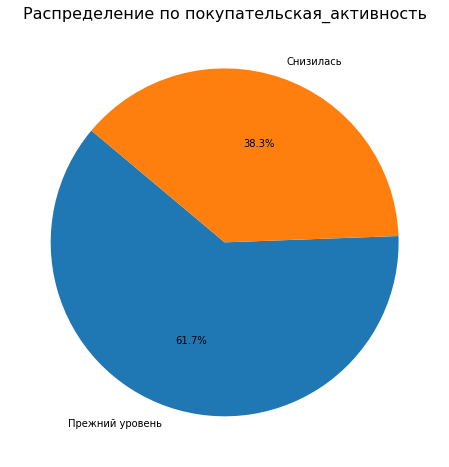

In [14]:
categoral_unique(market_file, 'покупательская_активность')

Видим некоторый дисбаланс значений в целевом признаке, это нужно будет учесть в модели.

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

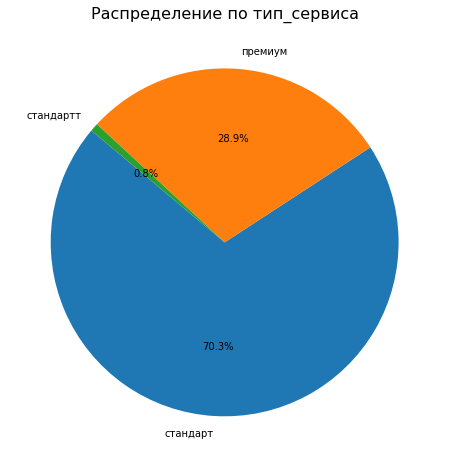

In [15]:
categoral_unique(market_file, 'тип_сервиса')

Обнаружилась опечатка.  
Так же обратим внимание, что премиум пользователей меньше, что и логично.

In [16]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace('стандартт', 'стандарт')

array(['да', 'нет'], dtype=object)

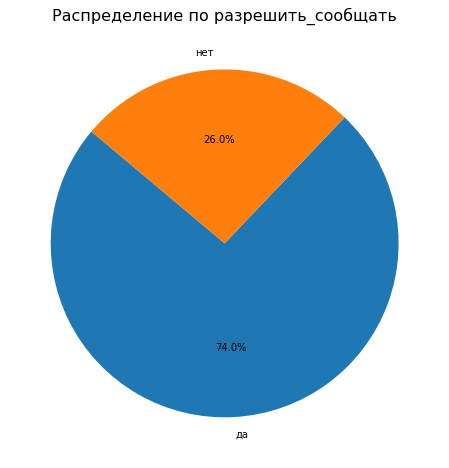

In [17]:
categoral_unique(market_file, 'разрешить_сообщать')

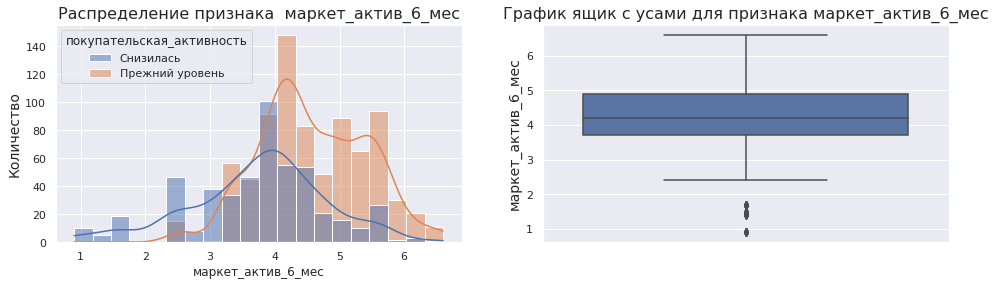

In [18]:
hist_with_wiskers(market_file, 'маркет_актив_6_мес', 'покупательская_активность')

In [19]:
market_file.query('маркет_актив_6_мес < 2')

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
30,215378,Снизилась,стандарт,да,1.7,3,488,0.39,Техника для красоты и здоровья,5,1,4,3
32,215380,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7
38,215386,Снизилась,стандарт,да,1.5,3,495,0.98,Домашний текстиль,2,3,7,5
47,215395,Снизилась,премиум,да,1.5,5,645,0.27,Товары для детей,3,3,6,5
55,215403,Снизилась,премиум,да,1.7,5,771,0.39,Техника для красоты и здоровья,1,8,2,5
61,215409,Снизилась,премиум,да,1.4,4,857,0.95,Кухонная посуда,3,4,5,5
63,215411,Снизилась,стандарт,да,1.7,4,756,0.33,Товары для детей,2,3,7,4
70,215418,Снизилась,стандарт,нет,1.7,4,472,0.94,Домашний текстиль,2,6,4,3
81,215429,Снизилась,премиум,нет,0.9,4,690,0.24,Домашний текстиль,2,5,7,4
108,215456,Снизилась,стандарт,да,1.7,4,449,0.23,Косметика и аксесуары,3,4,4,5


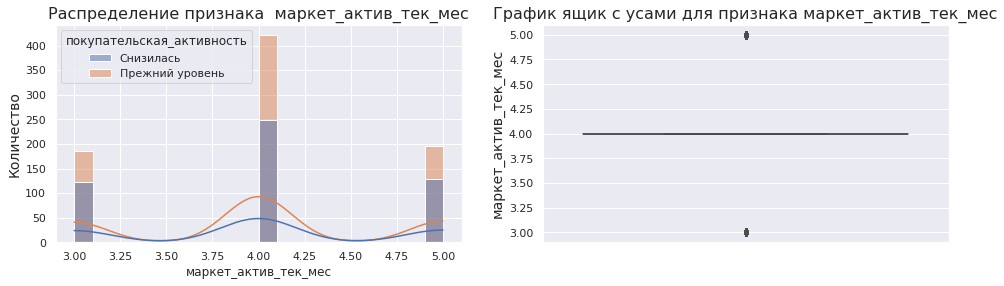

In [20]:
hist_with_wiskers(market_file, 'маркет_актив_тек_мес', 'покупательская_активность')

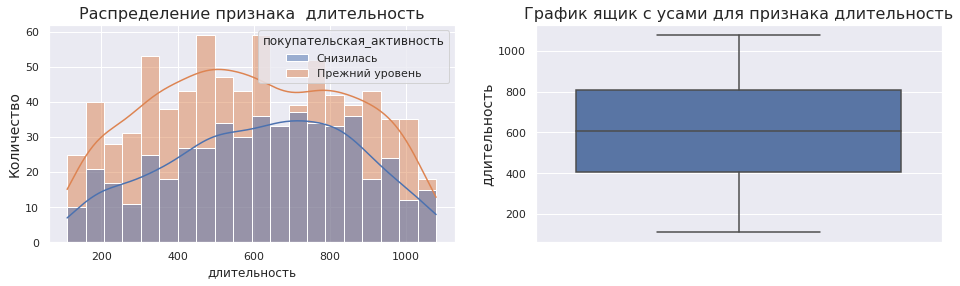

In [21]:
hist_with_wiskers(market_file, 'длительность', 'покупательская_активность')

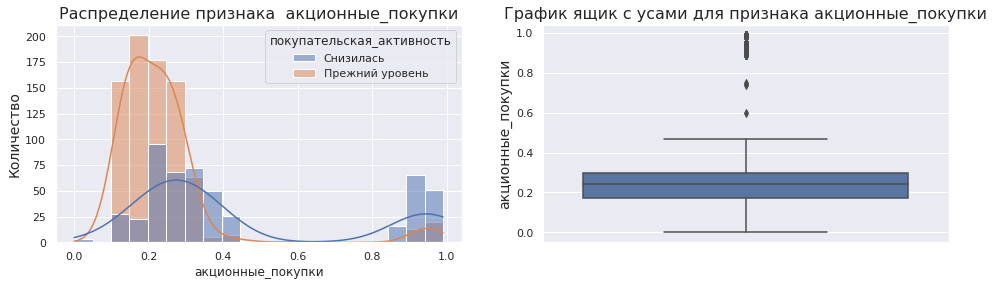

In [22]:
hist_with_wiskers(market_file, 'акционные_покупки', 'покупательская_активность')

Очень выглядит так, что большинство покупателей не ориентируются на скидки. Но тем не менее есть существенная часть клиентов, которые отлеживают скидки. Поэтому подготовке данных для модели разумным будет разделить пользователей на две части `Часто покупает по акции` и `Редко покупает по акции`, превратив колонку `Акционные_покупки` в категоральный признак.

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

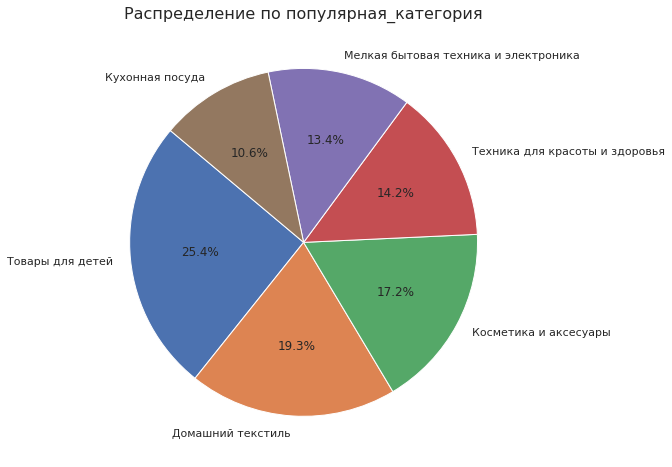

In [23]:
categoral_unique(market_file, 'популярная_категория') 

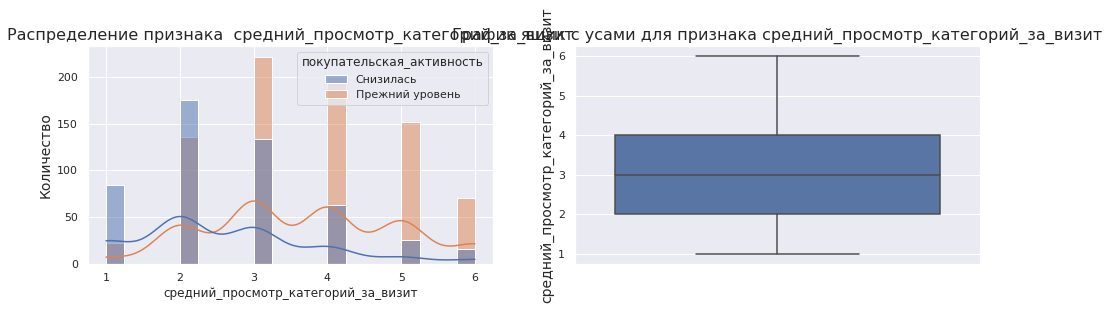

In [24]:
hist_with_wiskers(market_file, 'средний_просмотр_категорий_за_визит', 'покупательская_активность')

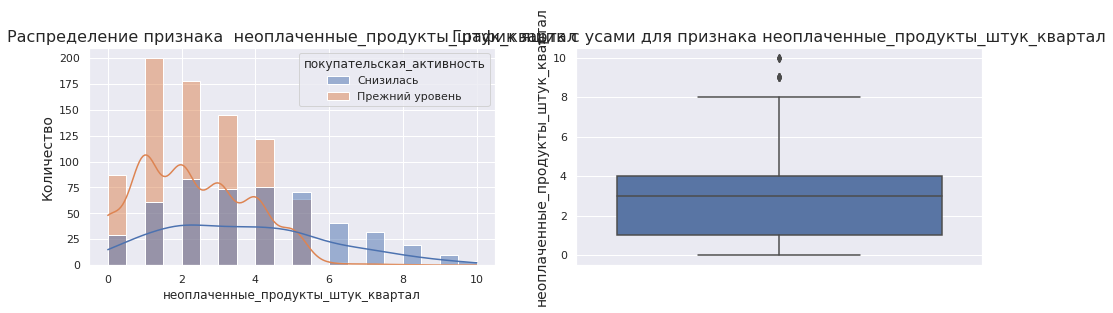

In [25]:
hist_with_wiskers(market_file, 'неоплаченные_продукты_штук_квартал', 'покупательская_активность')

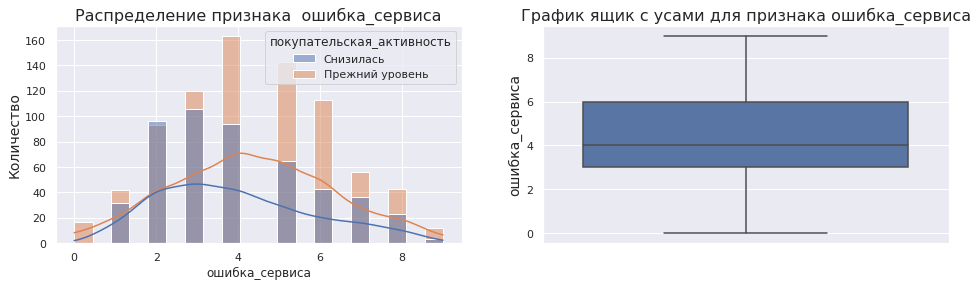

In [26]:
hist_with_wiskers(market_file, 'ошибка_сервиса', 'покупательская_активность')

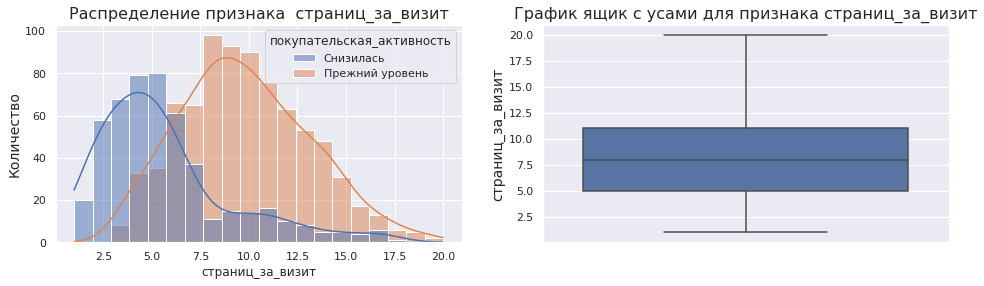

In [27]:
hist_with_wiskers(market_file, 'страниц_за_визит', 'покупательская_активность')

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

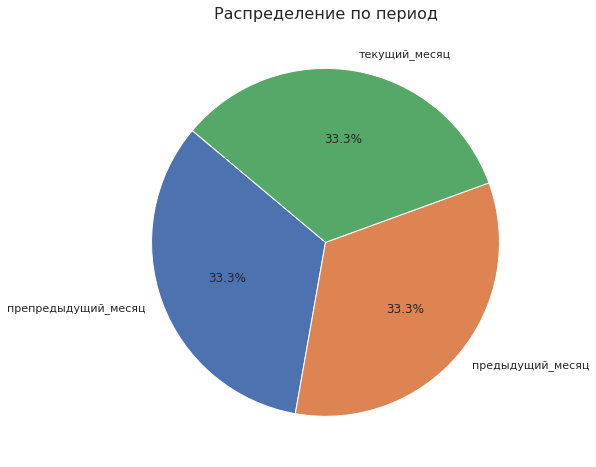

In [28]:
categoral_unique(market_money, 'период') 

In [29]:
market_money_by_period = market_money.pivot_table(index='период', values=['выручка'], aggfunc='sum')
market_money_by_period

,выручка
период,
предыдущий_месяц,6417996.5
препредыдущий_месяц,6272769.0
текущий_месяц,6909449.1


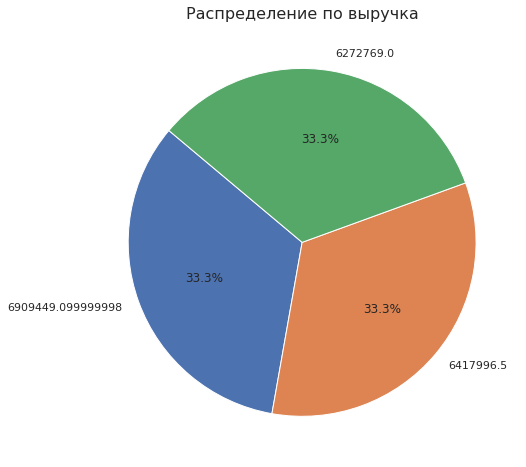

In [30]:
pivot_pie_chart(market_money_by_period, 'выручка') 

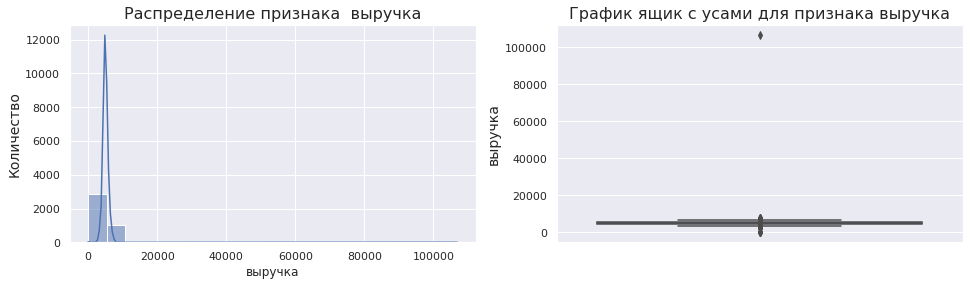

In [31]:
hist_with_wiskers(market_money, 'выручка', None)

Скорее всего это выброс, который помешает нам в будущем

In [32]:
market_money.query('выручка > 100000')

,id,период,выручка
98,215380,текущий_месяц,106862.2


In [33]:
market_money = market_money[market_money['выручка'] < 100000]

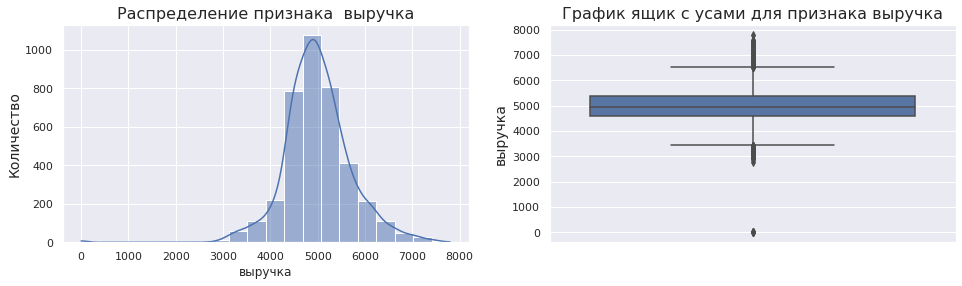

In [34]:
hist_with_wiskers(market_money, 'выручка', None)

In [35]:
market_money.query('выручка < 1')

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


По заданию нам нужны только пользователи, которые совершали покупки

In [36]:
market_money = market_money[market_money['выручка'] > 0]

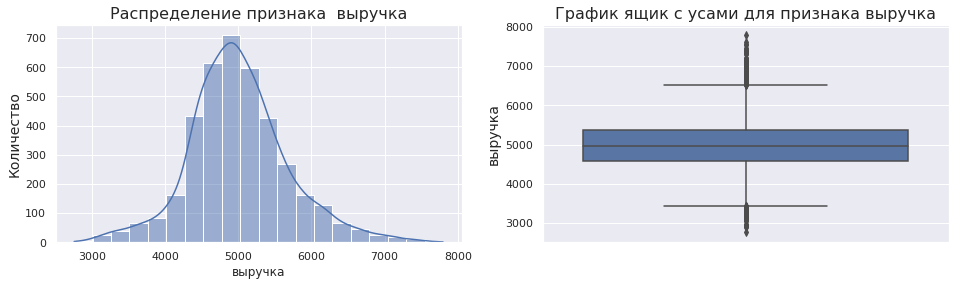

In [37]:
hist_with_wiskers(market_money, 'выручка', None)

**market_time**

In [38]:
market_time_by_period = market_time.pivot_table(index='период', values=['минут'], aggfunc='sum')
market_time_by_period

,минут
период,
предыдцщий_месяц,17508
текущий_месяц,17166


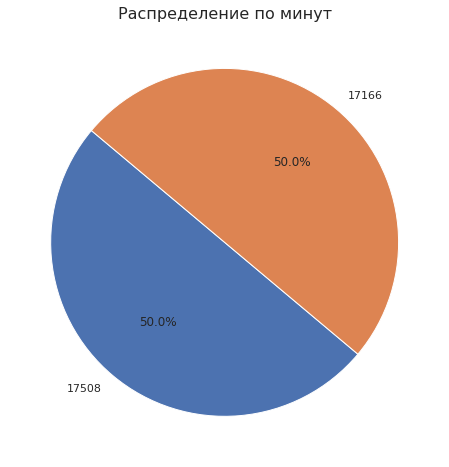

In [39]:
pivot_pie_chart(market_time_by_period, 'минут') 

In [40]:
market_time['период'] = market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

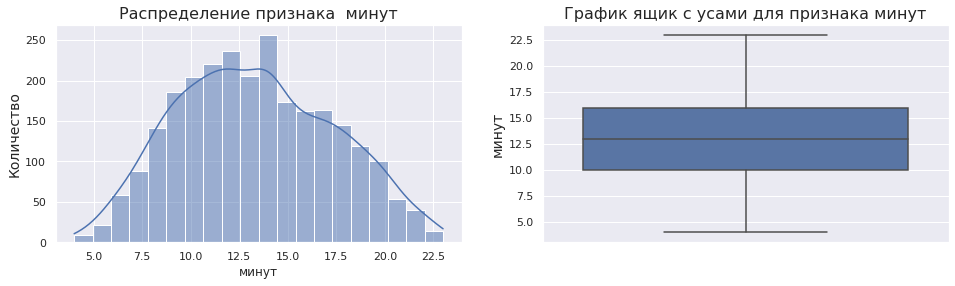

In [41]:
hist_with_wiskers(market_time, 'минут', None)

**money**

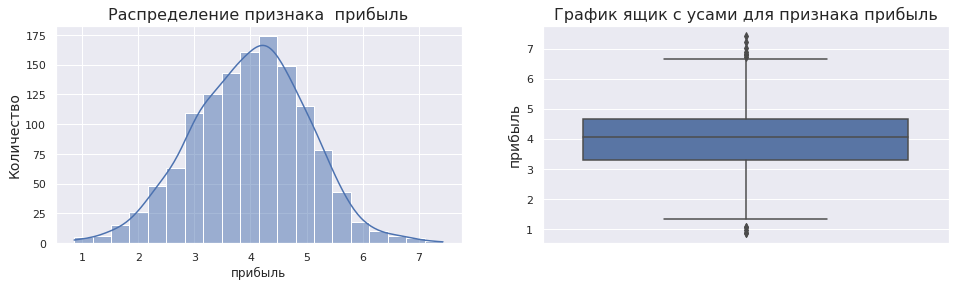

In [42]:
hist_with_wiskers(money, 'прибыль', None)

По заданию необходимо отобрать пользователей, чья активность более трёх месяцев

In [43]:
agg_dict = {'период': ['count']}
grouped = market_money.groupby('id').agg(agg_dict)
grouped.columns = ['count']

grouped = grouped[grouped['count'] == 3]
market_file = market_file[market_file['id'].isin(grouped.index)]
len(market_file)

1296

# Вывод
На данном этапе был проведен исследовательский анализ данных. В ходе работы были исправлены опечатки в данных, которые удалось хорошо найти по составленным графикам. Так же было выявлено небольшое количество явно аномальных значений, которые были отброшены из рассмотрения. В целом данные выглядят хорошо. Так же оставили только пользователей, совершавших покупки в течении трех последних месяцев.

* признак `актив_6_мес` в целом распределен нормально, есть несколько слишком малых значений. Надо иметь это ввиду, возможно придется их удалить;
* признак `актив_тек_мес` можно сделать категориальным признаком с 3-мя категориями;
* признак `длительность` в целом распределен равномерно на всём диапазоне значений;
* признак `акции` имеет бимодальное распределение - в области 0,2 и в области близкой к 1. Есть немалая доля покупателей, кто покупает только по акции! К ним нужно присмотреться повнимательней;
* признак `категорий_за_визит` имеет нормальное распределение, можно сделать категориальным признаком с 6 категориями;
* признак `неоплачено_штук` имеет слегка скорешенное влево распределение  - редко кто хранит в корзине больше 8 предметов - будет категориальным признаком с 11 категориями;
* признак `ошибки` распределен нормально - будет категориальным признаком с 10 категориями;
* признак `страницы` имеет слегка скошенное влево нормальное распределение.
* признак `выручка` распределен нормально, также имеются нулевые значения - это пользователи, которые не совершали покупок в указанные периоды. От них тоже придется "избавиться".
* Признак `минут` распределен нормально.
* Признак `прибыль` распределен нормально.

## Объединение таблиц

In [44]:
market_money_grouped = market_money.pivot_table(index=['id'], columns=["период"])
market_money_grouped.columns = ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']
market_money_grouped['id'] = market_money_grouped.index

market_time_grouped = market_time.pivot_table(index=['id'], columns=["период"])
market_time_grouped.columns = ['минут_предыдущий_месяц', 'минут_текущий_месяц']
market_time_grouped['id'] = market_time_grouped.index

market_full = market_file.join(market_money_grouped, on='id', lsuffix="_left", rsuffix="_выручка")
market_full = market_full.rename(columns={'id_left':'id'})
market_full = market_full.join(market_time_grouped, on='id', lsuffix="_left", rsuffix="_минут")
market_full = market_full.rename(columns={'id_left':'id'})
market_full = market_full.drop(['id_выручка', 'id_минут'], axis=1)
market_full.head(5)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [45]:
info_data(market_full)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10



<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 1 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская_активность            1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса               

None

,count,mean,std,min,25%,50%,75%,max
id,1296.0,215999.464506,374.327860,215349.00,215675.750,215999.50,216323.250,216647.00
маркет_актив_6_мес,1296.0,4.256404,1.013525,0.90,3.700,4.20,4.900,6.60
маркет_актив_тек_мес,1296.0,4.009259,0.696316,3.00,4.000,4.00,4.000,5.00
длительность,1296.0,602.967593,249.195823,121.00,409.500,606.50,806.250,1079.00
акционные_покупки,1296.0,0.320069,0.249159,0.11,0.170,0.24,0.300,0.99
средний_просмотр_категорий_за_визит,1296.0,3.267747,1.355125,1.00,2.000,3.00,4.000,6.00
неоплаченные_продукты_штук_квартал,1296.0,2.841821,1.974074,0.00,1.000,3.00,4.000,10.00
ошибка_сервиса,1296.0,4.184414,1.951719,0.00,3.000,4.00,6.000,9.00
страниц_за_визит,1296.0,8.187500,3.978459,1.00,5.000,8.00,11.000,20.00
выручка_предыдущий_месяц,1296.0,4947.468750,700.797239,2890.00,4498.125,5005.50,5405.625,6869.50



___________
Кол-во пропусков:
 id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
выручка_предыдущий_месяц               0
выручка_препредыдущий_месяц            0
выручка_текущий_месяц                  0
минут_предыдущий_месяц                 0
минут_текущий_месяц                    0
dtype: int64
___________
Кол-во явных дубликатов: 0
___________


# Вывод
Произвёл объединение таблиц и проверил полученную единую таблицу на пропуски и дубликаты.

## Корреляционный анализ

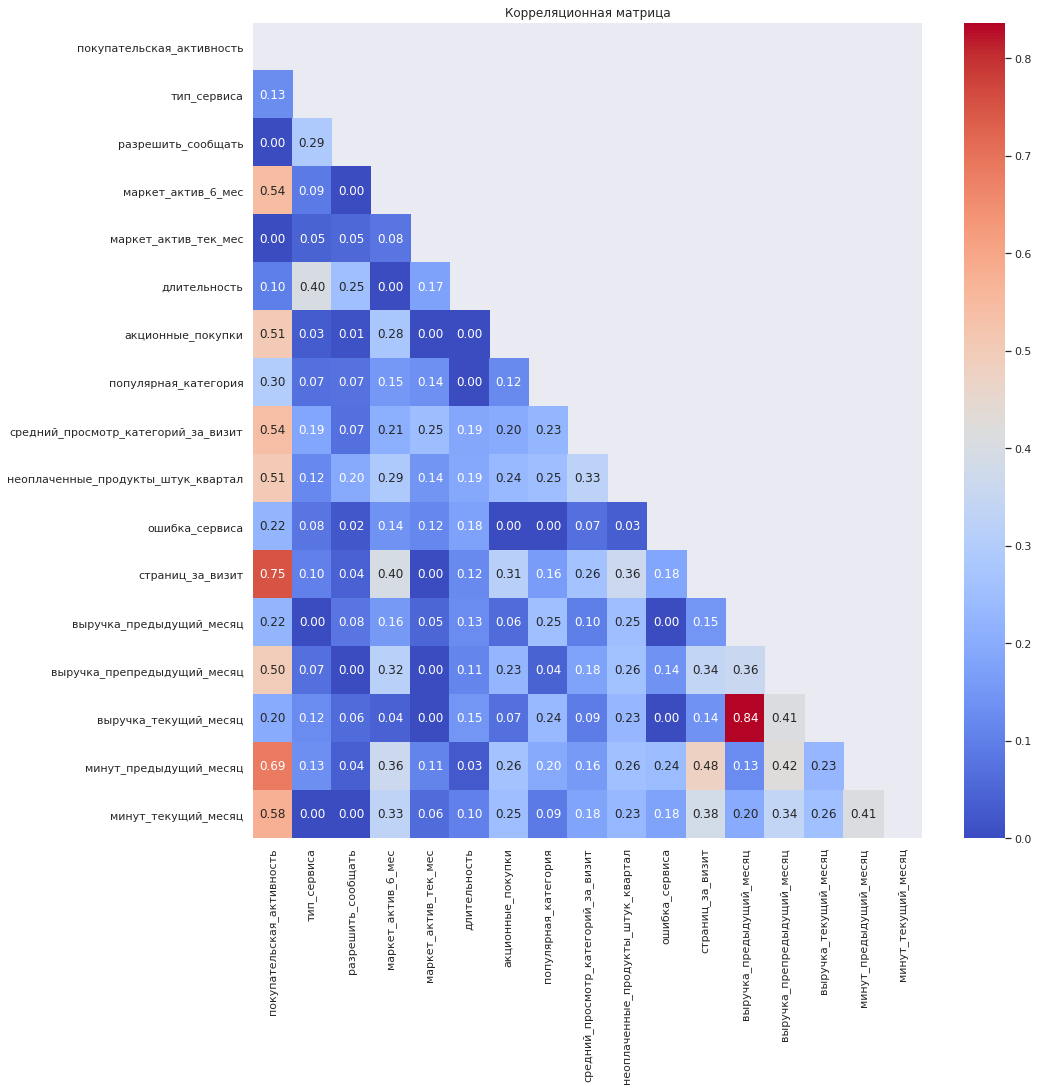

In [46]:
phik_matrix = market_full.drop('id', axis=1).phik_matrix(interval_cols=['маркет_актив_6_мес',
                                                                        'маркет_актив_тек_мес',
                                                                        'длительность',
                                                                        'акционные_покупки', 
                                                                        'средний_просмотр_категорий_за_визит',
                                                                        'неоплаченные_продукты_штук_квартал',
                                                                        'ошибка_сервиса',
                                                                        'страниц_за_визит',
                                                                        'выручка_предыдущий_месяц',
                                                                        'выручка_препредыдущий_месяц',
                                                                        'выручка_текущий_месяц',
                                                                        'минут_предыдущий_месяц',
                                                                        'минут_текущий_месяц'])

mask = np.triu(np.ones_like(phik_matrix, dtype=bool))

plt.figure(figsize=(15, 15))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)
plt.title("Корреляционная матрица")
plt.show()

In [47]:
market_full

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7


In [48]:
interval_cols = [
    'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 
    'акционные_покупки', 'средний_просмотр_категорий_за_визит', 
    'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 
    'страниц_за_визит', 'выручка_предыдущий_месяц', 
    'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 
    'минут_предыдущий_месяц', 'минут_текущий_месяц'
]

# Выбираем только числовые признаки
X = market_full[interval_cols]

# Добавляем константу
X = sm.add_constant(X)

# Вычисляем VIF для каждого признака
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                               Variable         VIF
0                                 const  352.524089
1                    маркет_актив_6_мес    1.220849
2                  маркет_актив_тек_мес    1.044578
3                          длительность    1.099452
4                     акционные_покупки    1.185679
5   средний_просмотр_категорий_за_визит    1.178602
6    неоплаченные_продукты_штук_квартал    1.198629
7                        ошибка_сервиса    1.079350
8                      страниц_за_визит    1.418264
9              выручка_предыдущий_месяц    4.263015
10          выручка_препредыдущий_месяц    1.612075
11                выручка_текущий_месяц    3.896191
12               минут_предыдущий_месяц    1.526838
13                  минут_текущий_месяц    1.321172


# Вывод

Целевым признаком является `Покупательская_активность` и вот список полей, которые имеют хоть корреляцию с ним: `Маркет_актив_6_мес`, `Акционные_покупки`, `Средний_просмотр_категорий_за_визит`, `Неоплаченные_продукты_штук_квартал`, `Страниц_за_визит`, `Выручка_препредыдущий_месяц`, `минут_предыдущий_месяц`, `минут_текущий_месяц`.  

После проверки мультиколлинеальности выяснилось, что у всех признаков, кроме `выручка_предыдущий_месяц` и `выручка_текущий_месяц`, мультиколлинеальности отсутсвует. А у этих двух признаков VIF < 5, что говорит о слабой мультиколлинеальности

## Использование пайплайнов

Подготовим данные. Закодируем целевой признак в значение 0 и 1. А так же превратим колонку `Акционные_покупки` в категоральный признак.

In [49]:
market_full['покупательская_активность'] = market_full['покупательская_активность']\
.apply( lambda x: 1 if x=='Снизилась' else 0 )
market_full['покупательская_активность'] = market_full['покупательская_активность'].astype(int)    

In [50]:
market_full['акционные_покупки_категория'] = market_full['акционные_покупки']\
.apply( lambda x: 'Часто покупает по акции' if x>= 0.5 else 'Редко покупает по акции' )
market_full = market_full.drop(['акционные_покупки'], axis=1)

In [51]:
market_full = market_full.set_index('id')

In [52]:
market_full.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,акционные_покупки_категория
id,,,,,,,,,,,,,,,,,
215349,1,премиум,да,4.4,4,819,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,Часто покупает по акции
215350,1,стандарт,нет,4.9,3,539,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,Редко покупает по акции
215351,1,стандарт,да,3.2,5,896,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,Часто покупает по акции
215352,1,стандарт,нет,5.1,3,1064,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,Часто покупает по акции
215353,1,стандарт,да,3.3,4,762,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,Редко покупает по акции


In [53]:
X = market_full.drop(['покупательская_активность'], axis=1)
y = market_full['покупательская_активность']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

In [54]:
ohe_columns = ['разрешить_сообщать', 'популярная_категория', 'тип_сервиса']
ord_columns = ['акционные_покупки_категория']
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'маркет_актив_тек_мес', 
               'длительность', 'средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 
               'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 
               'минут_предыдущий_месяц', 'минут_текущий_месяц']

In [55]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='error', sparse=False, drop='first'))
    ]
)

In [56]:
ord_pipe = Pipeline(
    [
        (
            'simple_imputer_ord_before',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(categories=[
                                      ['Редко покупает по акции','Часто покупает по акции']],
                          handle_unknown='use_encoded_value',
                          unknown_value=np.nan)
        ),
        (
            'simple_imputer_ord_after',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [57]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [58]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [59]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 7),
        'models__max_features': range(2,7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='poly')],
        'models__degree': range(2, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [60]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [61]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse=False))]),
                                                                               ['разрешить_сообщать',
                                                                                'популярная_категория',
                                                                                'тип_сервиса']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simple...
                                        {'models': [LogisticRegression(C=1,
                                                                       penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(kernel='poly',
                                                        random_state=42)],
                                         'models__degree': range(2, 3),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [62]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика по кросс валидацинной выборке:', round(randomized_search.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория',
                                                   'тип_сервиса']),
                                                 ('ord',
                                                  Pipeline(steps=[('simple_imput

In [63]:
y_test_pred = randomized_search.predict(X_test)
y_test_proba = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_test_proba[:,1]), 2)}')

Метрика ROC-AUC на тестовой выборке: 0.92


In [64]:
print(f'Метрика F1-score на тестовой выборке: {round(f1_score(y_test, y_test_pred, average="macro"), 2)}')

Метрика F1-score на тестовой выборке: 0.89


# Вывод

На данном шаге исследования была найдена и обучена модель для определения снижения активности покупателей сервиса. Лучшие результаты показала модель `LogisticRegression(C=2, penalty='l1', random_state=42, solver='liblinear')`. Метрика `roc_auc` для тестовой выборки показла результат 0.90, для кросс валидацинной 0.92. Модель хорошо справляется с предсказанием. Так же метрика `f1` показала и вовсе фантастические 0.90.  
Имеется дисбаланс в классах и все же он не помешал на получить такие высокие метрики.

## Анализ важности признаков

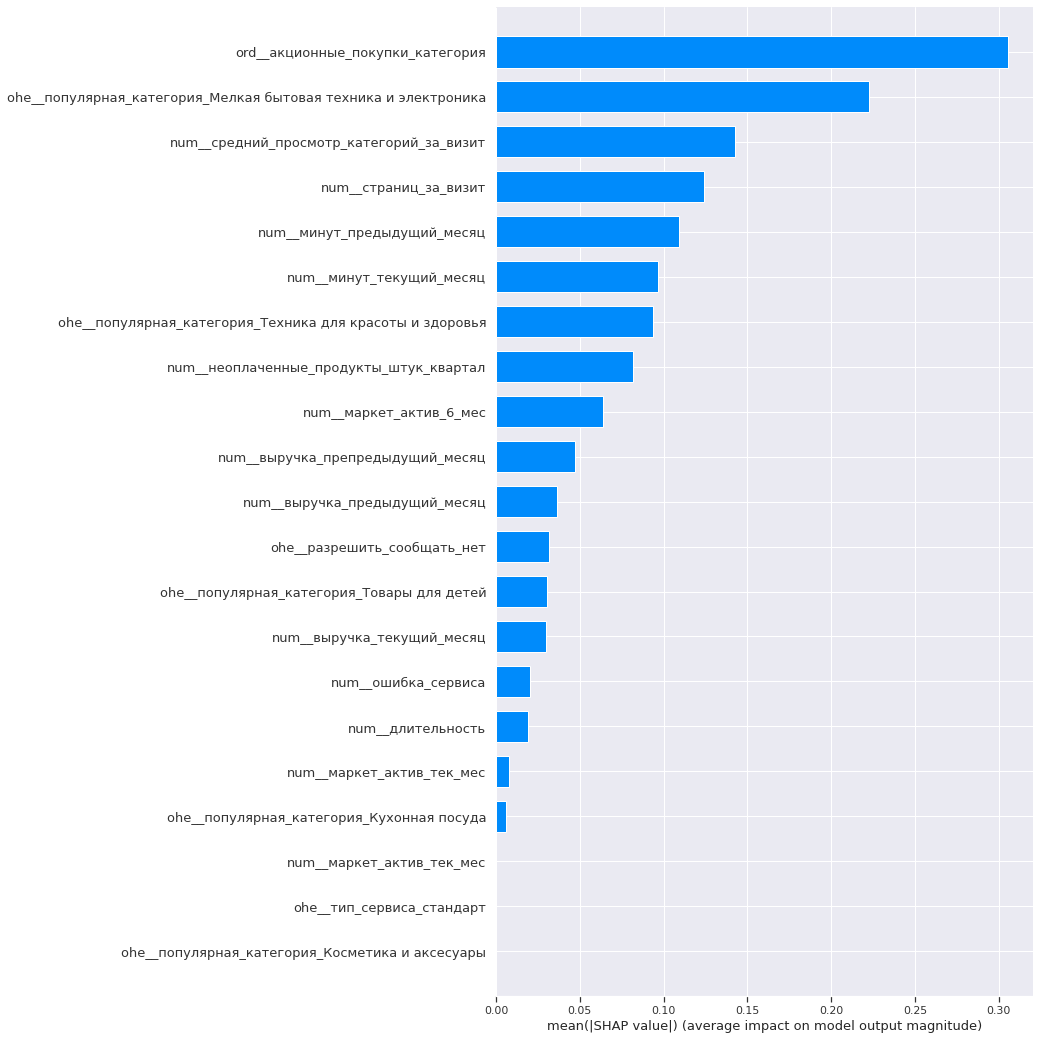

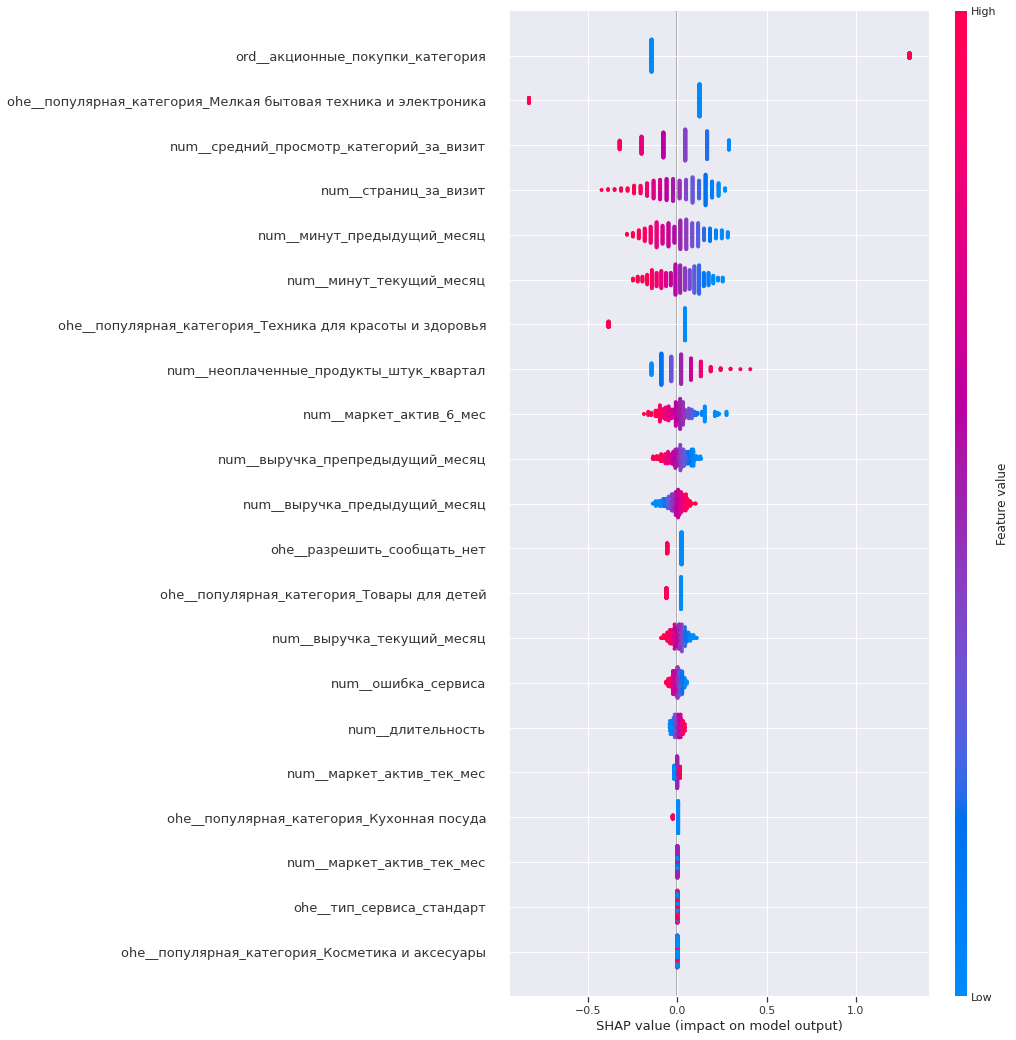

In [65]:
X_train_2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)

explainer = shap.LinearExplainer(randomized_search.best_estimator_.named_steps['models'], X_train_2)

X_test_2 = pipe_final.named_steps['preprocessor'].transform(X_test)

feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)

shap_values = explainer(X_test_2)




plt.rcParams.update({
    'font.size': 25,  
    'axes.titlesize': 25, 
    'axes.labelsize': 25, 
    'xtick.labelsize': 25,  
    'ytick.labelsize': 25,  
    'legend.fontsize': 25,  
    'figure.titlesize': 25 
})




shap.summary_plot(
    shap_values, 
    X_test_2, 
    plot_type="bar", 
    max_display=30, 
    plot_size=(15, 15) 
)


shap.summary_plot(
    shap_values, 
    X_test_2, 
    plot_type="dot", 
    max_display=30, 
    plot_size=(15, 15)  
)

plt.show()


In [66]:
market_full ['акционные_покупки_категория'].value_counts()

Редко покупает по акции    1129
Часто покупает по акции     167
Name: акционные_покупки_категория, dtype: int64

# Вывод
Для модели выжны следующие признаки это: `Акционные покупки`, `Мелкая бытовая техника и электроника`, `Просмотр категорий за визит`, `Страниц за визит`, `Минуты в предыдущий месяц`.  
Малозначимыми признаками оказались:`Популярная категория`(кроме бытовой техники и техники для красоты и здоровья), `Маркет_актив_тек_мес`, `Разрешить сообщать`, `Тип_сервиса`.


По графику beeswarm видно:
- `ord_акционные_покупки_категория`: Высокие значения этого признака увеличивают SHAP значения и, следовательно, увеличивают вероятность того, что покупательная активность снизится. Это означает, что наличие акционных покупок больше связано со снижением покупательной активности.
- `num_средний_просмотр_категорий_за_визит ` и `num_страницы_за_визит` : Низкие значения этих признаков увеличивают SHAP значения, что указывает на увеличение вероятности снижения покупательной активности. То есть чем меньше человек просмотрит категорий и посетит страниц за визит, тем выше вероятность того, что его покупательная активность снизится.

- `num_минут_текущий_месяц` и `num_минут_предыдущий_месяц`: Эти признаки имеют смешанное влияние, где высокие значения могут как увеличивать, так и уменьшать вероятность целевого события, в зависимости от конкретного случая.

- Остальные признаки также имеют влияние, но оно менее выражено.

## Сегментация покупателей

In [67]:
y_test_proba = randomized_search.predict_proba(X_test)[:,1]
y_train_proba = randomized_search.predict_proba(X_train)[:,1]

In [68]:
X_test_full = X_test.copy()
X_train_full = X_train.copy()
X_test_full['вероятность_снижения'] = y_test_proba
X_train_full['вероятность_снижения'] = y_train_proba
df_full = pd.concat([X_train_full, X_test_full])

money = money.set_index('id')
df_full = df_full.join(money)


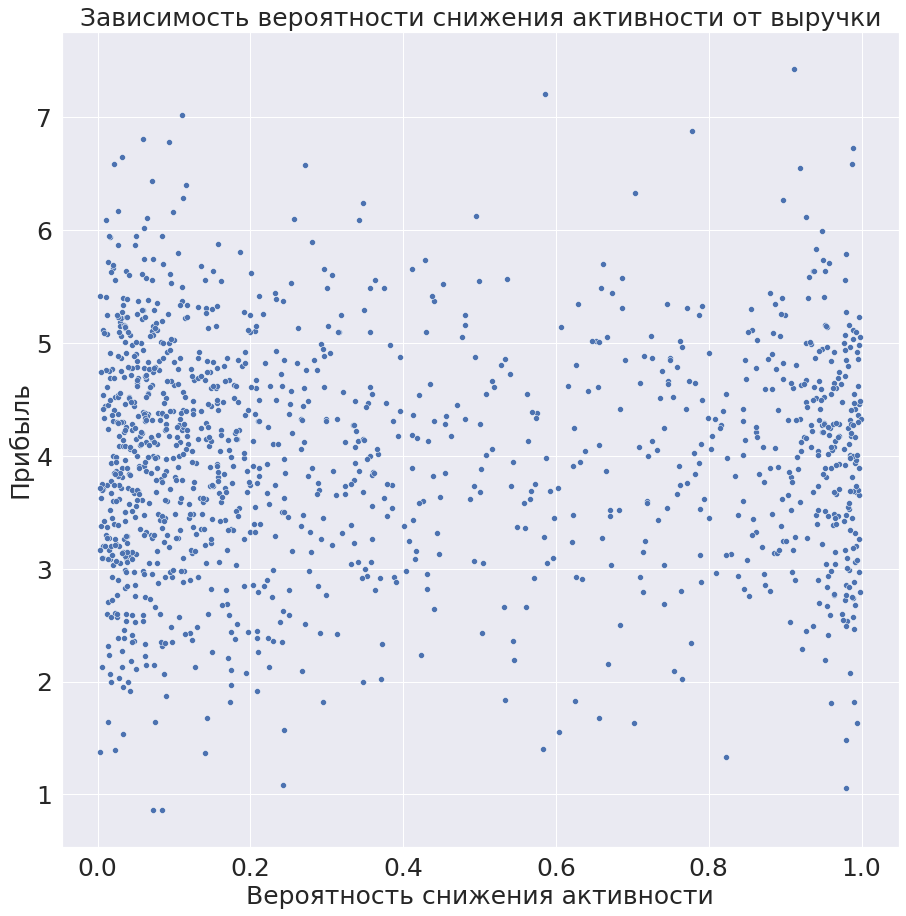

In [69]:
fig = plt.figure(figsize=(15,15))
sns.scatterplot(data=df_full, y='прибыль', x='вероятность_снижения')
plt.xlabel('Вероятность снижения активности')
plt.ylabel('Прибыль')
plt.title('Зависимость вероятности снижения активности от выручки')
plt.show()

Получили диаграмму рассеинья Прибыли и Вероятности снижения активности покупателя. Я не вижу зависимости вероятности снижения активности пользователя от прибыли.  

In [70]:
def build_scatterplots(cat_columns):
    for cat_col in cat_columns:
        fig = plt.figure(figsize=(15,15))
        sns.scatterplot(data=df_full, y='прибыль', x='вероятность_снижения', hue=cat_col)
        plt.xlabel('Вероятность снижения активности')
        plt.ylabel('Прибыль')
        plt.title('Зависимость вероятности снижения активности от выручки')
        plt.show()

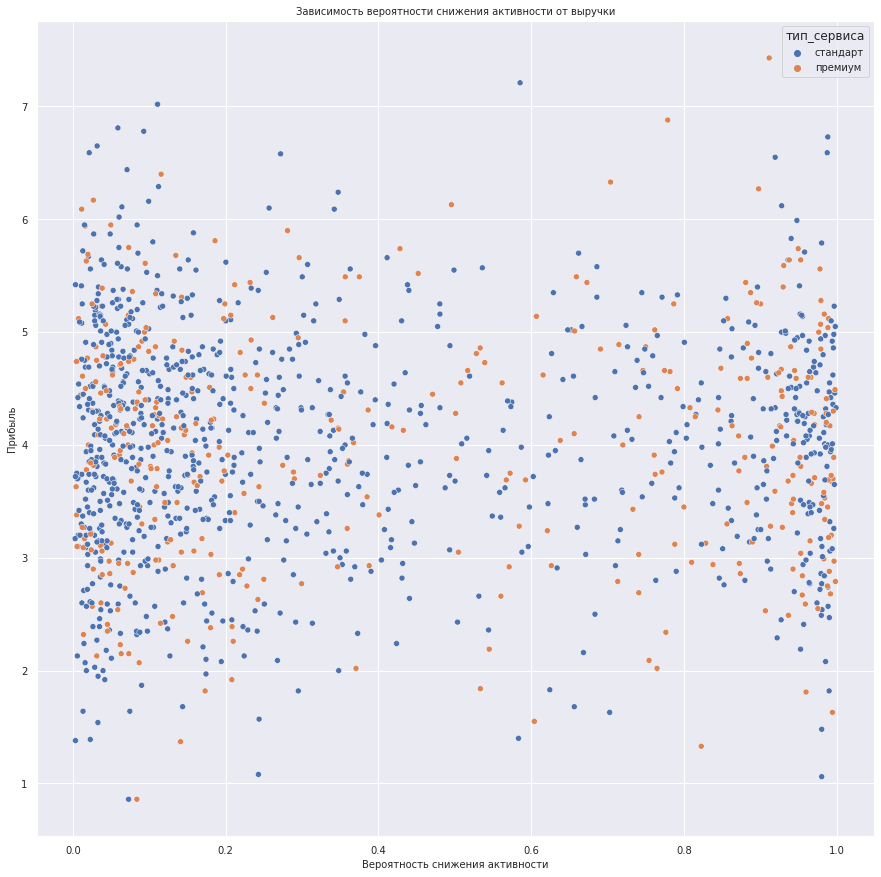

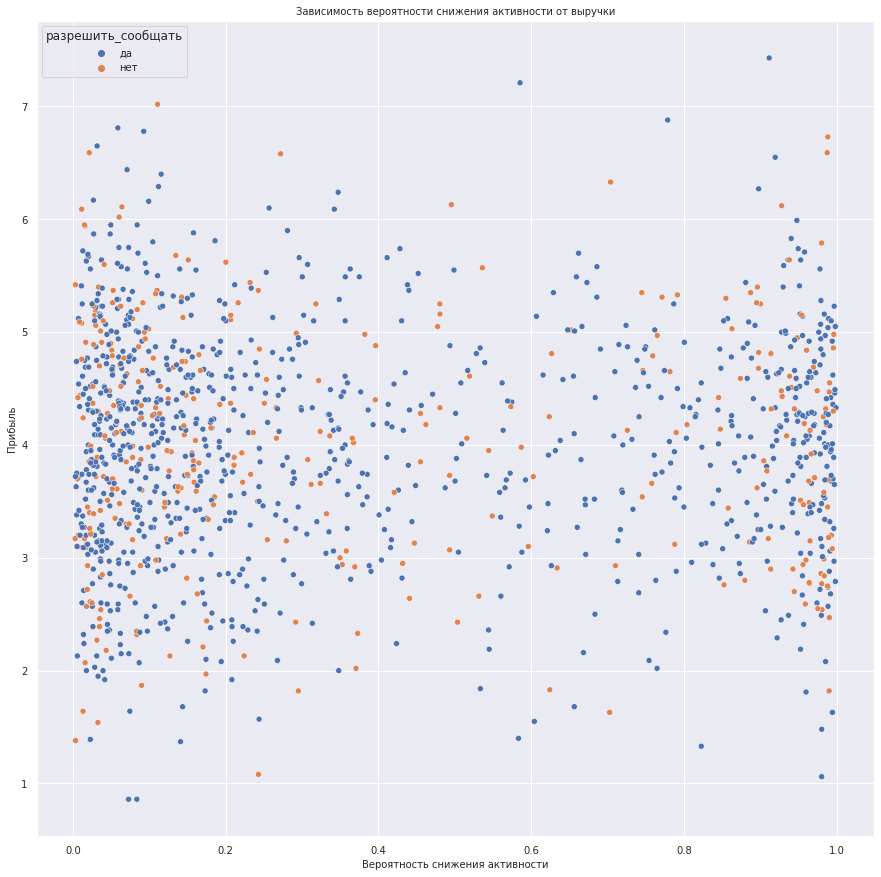

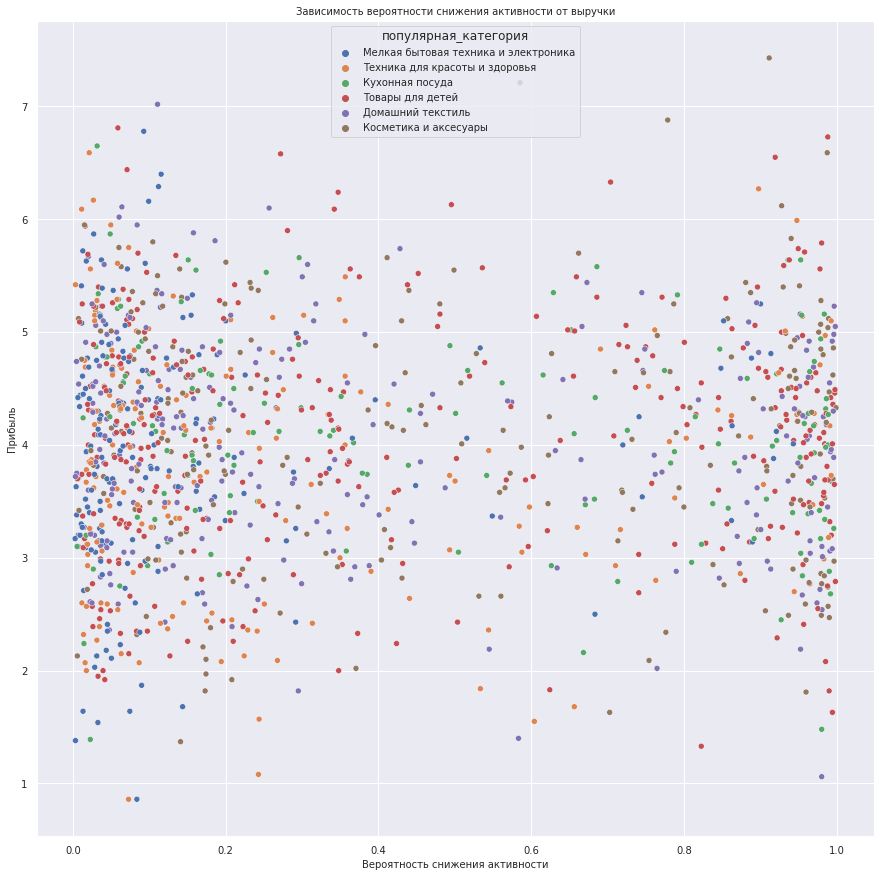

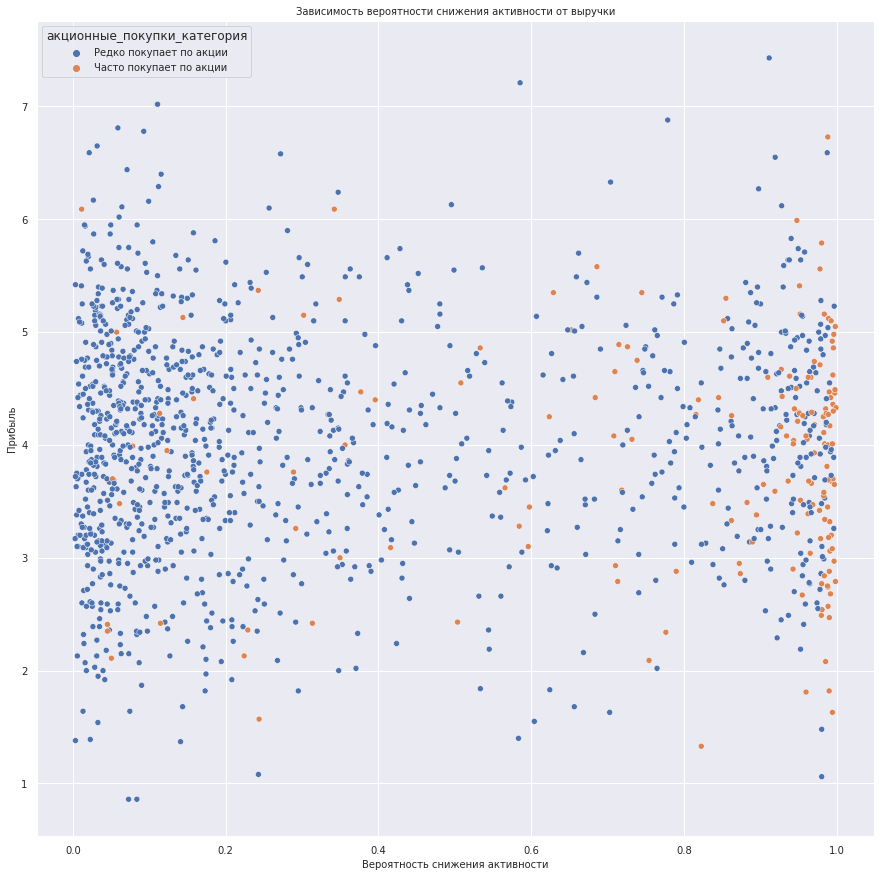

In [71]:
plt.rcParams.update({
    'font.size': 10,  
    'axes.titlesize': 10, 
    'axes.labelsize': 10, 
    'xtick.labelsize': 10,  
    'ytick.labelsize': 10,  
    'legend.fontsize': 10,  
    'figure.titlesize':10 
})
cat_columns = list(df_full.select_dtypes(include='object').columns)
build_scatterplots(cat_columns)

По графикам больше всего бросается в глаза это распределение `Акционные_покупки_категория`. Пользователи, которые часто покупают по скидке чаще всего имеют высокую вероятность снижения активности. Скидки не постоянно бывают, значит и покупки этот сегмент пользователей совершает так сказать сезонно. И более того пользователи покупающие в основном по скидке прдставлены по всему распределению прибыли.

In [72]:
df_full.head(4)

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,акционные_покупки_категория,вероятность_снижения,прибыль
id,,,,,,,,,,,,,,,,,,
215858,стандарт,да,5.5,4,510,Мелкая бытовая техника и электроника,2,4,7,16,5170.5,4347.0,6014.2,20,6,Редко покупает по акции,0.066247,4.37
215361,стандарт,да,5.1,4,199,Техника для красоты и здоровья,4,5,2,3,6400.0,4597.0,3789.7,11,13,Редко покупает по акции,0.780843,4.03
215884,стандарт,да,4.3,5,997,Мелкая бытовая техника и электроника,5,1,3,11,4113.0,4626.0,3798.4,13,10,Редко покупает по акции,0.083982,4.37
216564,стандарт,да,5.6,4,342,Кухонная посуда,2,7,5,8,4930.0,5269.0,4766.2,14,19,Часто покупает по акции,0.685967,5.58


In [73]:
df_full['сегмент'] = df_full\
.apply( lambda row: 'Исследуемый сегмент' \
        if row['вероятность_снижения'] > 0.8 and row['акционные_покупки_категория']=='Часто покупает по акции' \
        else 'Остальные пользователи' \
      , axis=1)

array(['Домашний текстиль', 'Косметика и аксесуары', 'Товары для детей',
       'Кухонная посуда', 'Техника для красоты и здоровья',
       'Мелкая бытовая техника и электроника'], dtype=object)

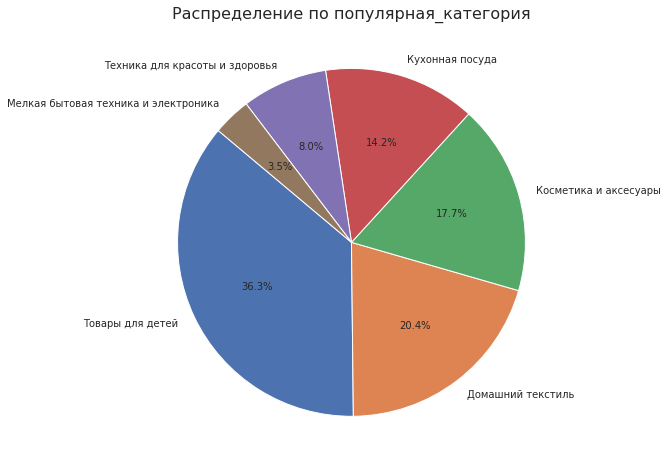

In [74]:
categoral_unique(df_full[df_full['сегмент'] == 'Исследуемый сегмент'], 'популярная_категория')

Видимо, дополнительные расходы, которые накладывает на семью ребёнок, заставляет людей чаще покупать товары по скидкам.

array(['премиум', 'стандарт'], dtype=object)

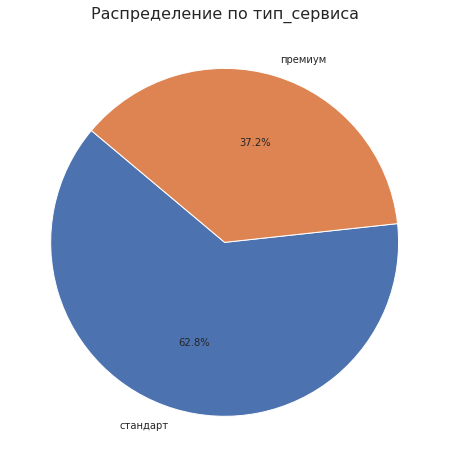

In [75]:
categoral_unique(df_full[df_full['сегмент'] == 'Исследуемый сегмент'], 'тип_сервиса')

Похоже, что люди, которые совершают покупки по скидкам стараются экономить на всём, в том числе и на подписках

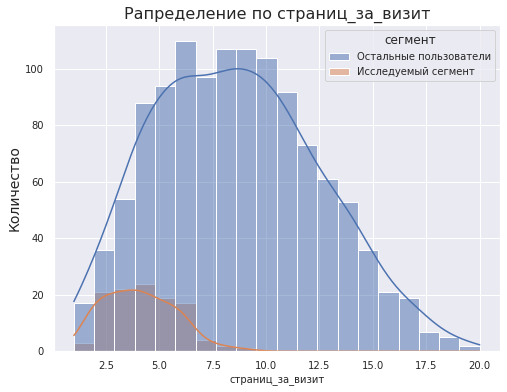

In [76]:
histogram(df_full, 'страниц_за_визит', 'сегмент')

Видно по пользователи по скидке просматривают меньше страниц. Похоже на то что эти пользователи не ищут и выбирают, а покупают целенаправленно.

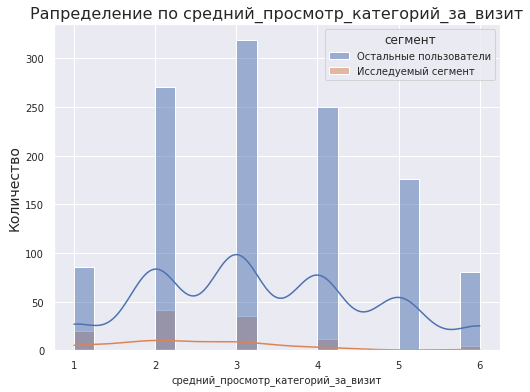

In [77]:
histogram(df_full, 'средний_просмотр_категорий_за_визит', 'сегмент')

В среднее кол-во просматриваемых категорий не различается.

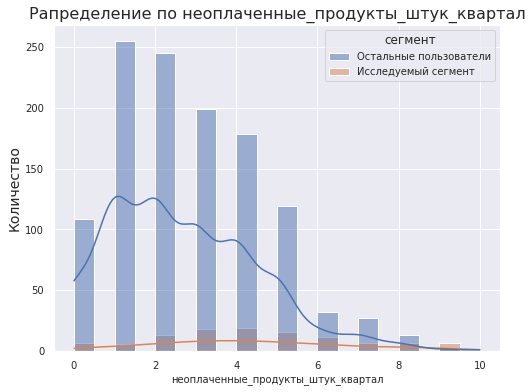

In [78]:
histogram(df_full, 'неоплаченные_продукты_штук_квартал', 'сегмент')

Пользователи из иследуемого сегмента в среднем оставляют неоплаченными в корзине больше товаров.

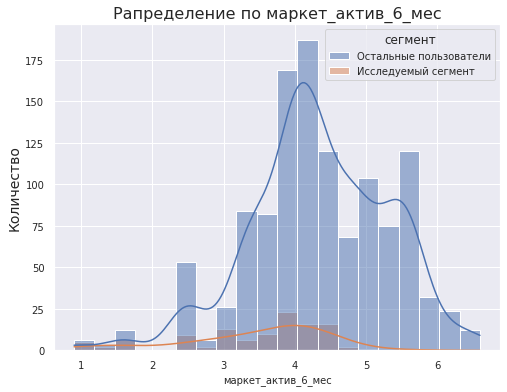

In [79]:
histogram(df_full, 'маркет_актив_6_мес', 'сегмент')

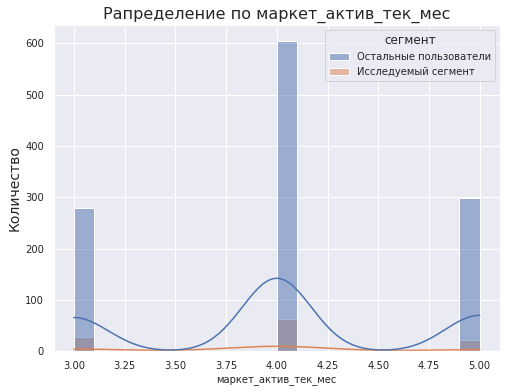

In [80]:
histogram(df_full, 'маркет_актив_тек_мес', 'сегмент')

Скорее всего, магазин не предоставляет пользователям каких либо дополнительных источников получения информации о скидках

## Общий вывод

Задачей данного иссследования было построение модели, которая бы предсказала уменьшение покупательской активности пользователей интернет-магазина "В один клик".  
Другой задачей было исследование выбранного сегмента пользователей.

В рамках исследования были проделаны следующие шаги.  
  
#### Загрузка данных 

Исходными данными для исследования были четыре отдельных csv файла:
* с данными о поведении покупателя на сайте, коммуникации с ним и его продуктовом поведении. 
* с данными о выручке, которую получает магазин с покупателя за период
* с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода
*  данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю
Данные были загружены в датафреймы библиотеки pandas.

#### Предобработка данных

Исходные данные оказались хорошего качества, но тем не менее они требовали проведения некоторых работ перед началом анализа.
Во-первых стандартизация имен признаков. Наименования были оставлены на кириллице, но пробелы были заменены на землю.   
Во-вторых обработка пропусков. Пропусков в данных не было найдено.

#### Исследовательский анализ данных

На этом этапе были построены диаграммы распределения всех признаков. С помощью графиков были обнаружены и исправлены опечатки в категоральных признаках. Так же отметим, что график распределения признака `Акционные_покупки` явно выделял две группы пользователей поэтому признак был превращен в категориальный.

#### Корреляционный анализ данных

Целевым признаком является `Покупательская_активность` и вот список полей, которые имеют хоть корреляцию с ним: `Маркет_актив_6_мес`, `Акционные_покупки`, `Средний_просмотр_категорий_за_визит`, `Неоплаченные_продукты_штук_квартал`, `Страниц_за_визит`, `Выручка_препредыдущий_месяц`, `минут_предыдущий_месяц`, `минут_текущий_месяц`.  
Сильной корреляции между другими признаками не было выявлено поэтому все остальные признаки были оставленны в датасете.

Проверка на мультиколлинеарность не выявила сильных зависимостей между признаками.

#### Объеденение таблиц

Датасеты `market_file`, `market_money`, `market_time` были объеденены в один датафрейм.

#### Обучение модели

С использованием пайпланов из библиотеки sklearn были обучены модели KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC(). При обучении моделей средстави пайплана преебирались некоторое количество гиперпараметров моделей с целью нахождения модели, которая даст лучший результат.  
По результатам обучения лучшей стала модель `LogisticRegression(C=2, penalty='l1', random_state=42, solver='liblinear')`. Метрика roc_auc для тренеровочной выборки 0.90 для тестовой 0.92. Удивительно, но значения метрики имеют такой низкий разброс. И даже наличие дисбаланса в целевом признаке не помешало получить значение метрики f1=0.90.

#### Анализ важности признаков

Если коротко, то самыми важными оказались признаки связанные с аукционными товарами и с количеством времени, которое покупатель проводит на меркет плейсе. А наименее важными, категории товаров, котоыре интересовали пользователи и коммуникации с пользователем.  
Кажется что все эти маркетинговые завлекаловки и спам на почту не помогают маркетплейсу. Важно лишь заставить пользователя проводить на сайте как можно больше времени и продажи выростут.

#### Сегментация пользователей

Для анализа пользователей был выбран сегмент пользователей часто покупающих по скидке и в то же время имеющийх высокую вероятность снижения покупательской активности. Мое предложение по увеличение актвности этого сегмента покупателей это таргетированная настройка главной страницы маркетплейса. А так же более частое обновление скидок на главной странице. Пользователь не хочет ходить по страницам, он хочет видеть все предложения в одном месте. 